In [1]:
# ===== examples/basic.py =====
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from week4.core import Sequence, Pulse
from week4.plot import plot_matplotlib
import matplotlib.pyplot as plt



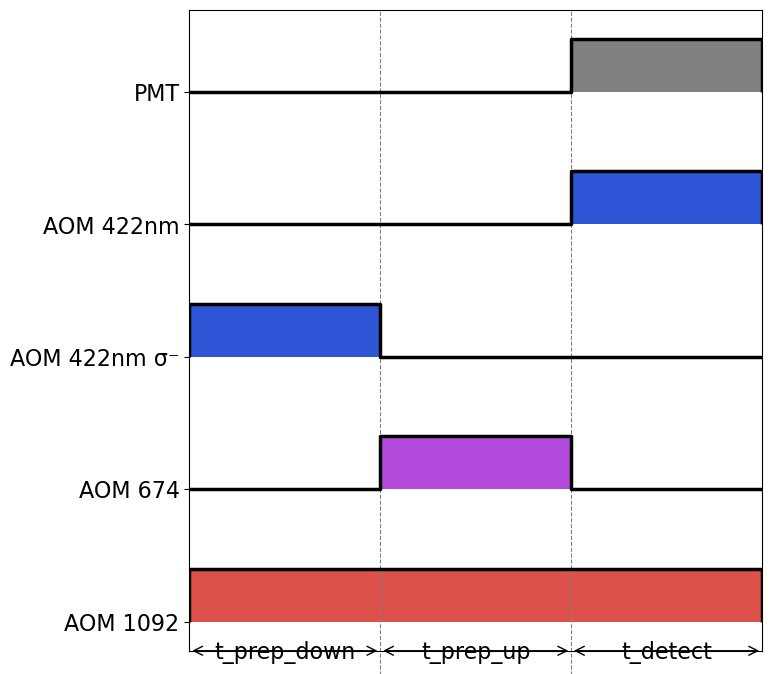

In [ ]:
import json
from week4.core   import Sequence
from week4.config import RC_PARAMS
import matplotlib as mpl
import matplotlib.pyplot as plt

# 1) Configure global style
mpl.rcParams.update(RC_PARAMS)

# 2) Load JSON and build Sequence
with open("StatePrepDetect.json") as f:
    data = json.load(f)

seq    = Sequence.from_dict(data)         # you’ll need a .from_dict constructor
labels = data.get("labels", [])           # extract the labels list
title  = data.get("title", None)
# 3) Plot
fig, ax = seq.plot(labels=labels)
fig.tight_layout()
plt.show()


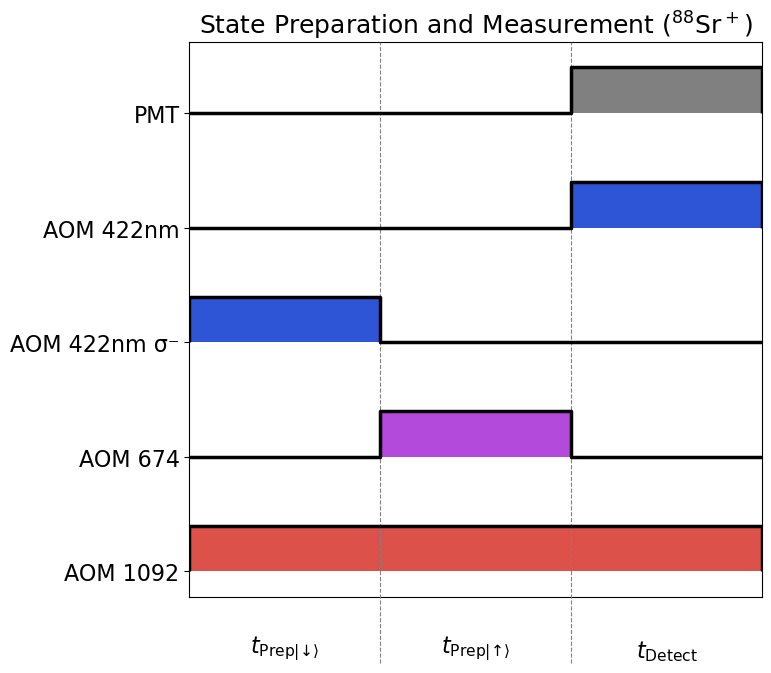

In [6]:

plt.rcParams.update({
    'font.size':       16,   # base size for text
    'axes.titlesize':  18,   # title
    'axes.labelsize':  16,   # x/y labels
    'xtick.labelsize': 16,   # tick labels
    'ytick.labelsize': 16,
})

# 1) Durations
t_prep, t_pulse, t_det= 30, 30, 30
boundaries = [
    0,
    t_prep,
    t_prep + t_pulse,
    t_prep + t_pulse + t_det
]
labels = [
    r'$t_{\mathrm{Prep |↓⟩}}$',
    r'$t_{\mathrm{Prep |↑⟩}}$',
    r'$t_{\mathrm{Detect}}$'
]

# 2) Build sequence
seq = Sequence([
    Pulse('PMT', t_prep + t_pulse ,              t_det,            'grey'),
    Pulse('AOM 422nm', t_prep + t_pulse ,              t_det,           "#2E55D6"),
    Pulse('AOM 422nm σ⁻', 0, t_prep,             "#2E55D6"),
    Pulse('AOM 674',  t_prep,t_pulse           , "#B34ADC"),
    Pulse('AOM 1092', 0, t_prep + t_pulse + t_det, "#DC514A"),
])

# 3) Plot static bars
channel_order = ['PMT','AOM 422nm', 'AOM 422nm σ⁻', 'AOM 674', 'AOM 1092']
fig, ax = plot_matplotlib(seq, channel_order=channel_order)
ax.invert_yaxis()
ax.set_xlim(0, boundaries[-1])
ax.set_xticklabels([])
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.set_title(r'State Preparation and Measurement ($^{88}$Sr$^+$)')

# # 4) Remove rectangle borders & send bars behind
# for p in ax.patches:
#     p.set_edgecolor('none')
#     p.set_zorder(1)



# 6) Separator lines and arrows
# To extend the separator lines below the x-axis, use ax.transAxes for ymin/ymax in axes coordinates.
for t in boundaries[1:-1]:
    ax.axvline(
        t,
        linestyle='--',
        color='grey',
        linewidth=0.8,
        zorder=4,
        ymin=-0.12,  # full axis range in data coordinates
        ymax=1.0,
        clip_on=False  # allow line to extend outside the axes
    )
    # Draw an extra line in axes coordinates to extend below x-axis
    #ax.plot([t, t], [-0.3, 0], color='grey', linestyle='--', linewidth=0.8, zorder=4, transform=ax.get_xaxis_transform())

y_top = len(channel_order) - 0.5
for start, end, text in zip(boundaries, boundaries[1:], labels):
    ax.annotate('', xy=(start, y_top), xytext=(end, y_top),
                arrowprops=dict(arrowstyle='<->', lw=1), zorder=6)
    ax.text((start+end)/2, y_top+0.3, text,
            ha='center', va='bottom', zorder=6)

fig.tight_layout()
plt.show()


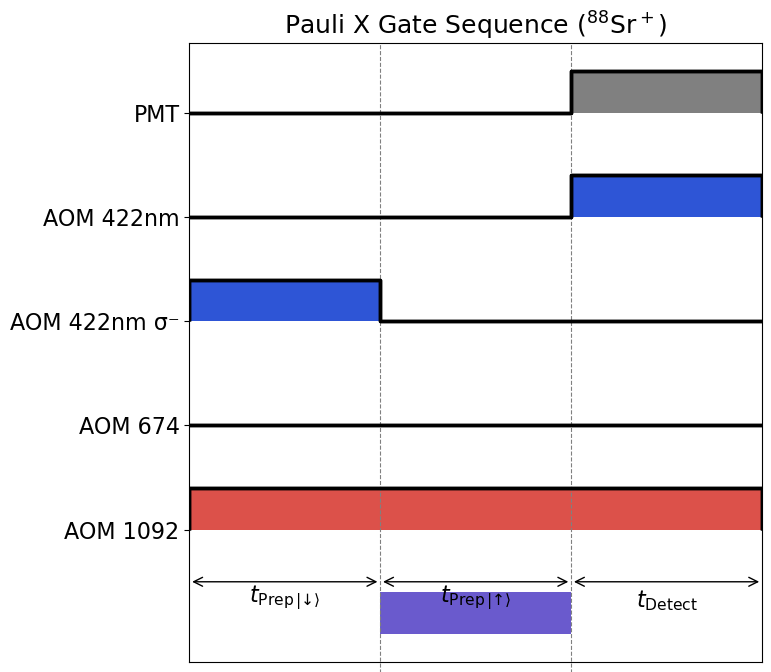

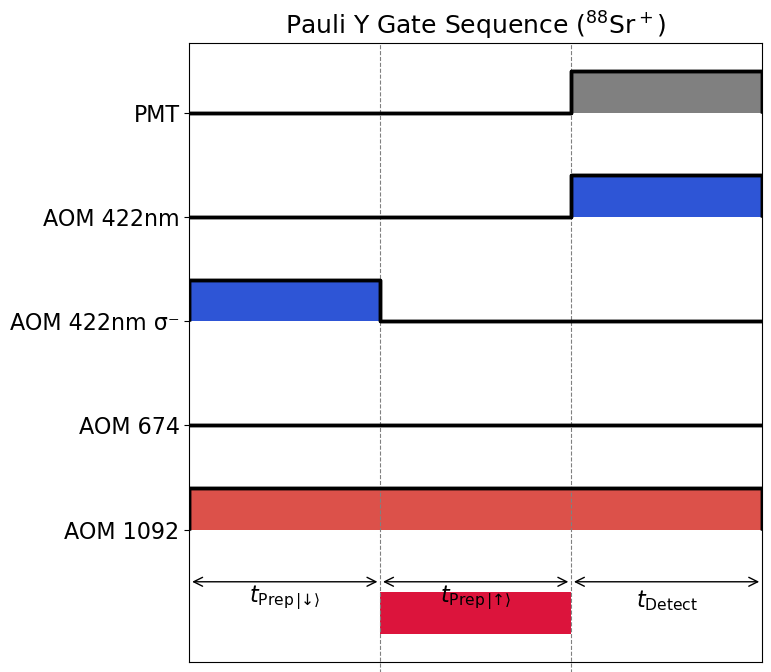

In [4]:


plt.rcParams.update({
    'font.size':       16,
    'axes.titlesize':  18,
    'axes.labelsize':  16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
})

# common durations
t_prep, t_pulse, t_det = 30, 30, 30
boundaries = [0, t_prep, t_prep + t_pulse, t_prep + t_pulse + t_det]
labels = [
    r'$t_{\mathrm{Prep\,|↓\rangle}}$',
    r'$t_{\mathrm{Prep\,|↑\rangle}}$',
    r'$t_{\mathrm{Detect}}$'
]
channel_order = ['PMT','AOM 422nm', 'AOM 422nm σ⁻', 'AOM 674', 'AOM 1092']

def plot_pauli_gate(gate):
    # pick label and (optional) color based on gate
    if gate == 'X':
        pulse_label = 'AOM 674, θ=0 (X)'
        pulse_color = '#6A5ACD'
    elif gate == 'Y':
        pulse_label = 'AOM 674, θ=π/2 (Y)'
        pulse_color = '#DC143C'
    else:
        raise ValueError("gate must be 'X' or 'Y'")

    seq = Sequence([
        Pulse('PMT',           t_prep + t_pulse,         t_det,            'grey'),
        Pulse('AOM 422nm',     t_prep + t_pulse,         t_det,           "#2E55D6"),
        Pulse('AOM 422nm σ⁻',  0,                        t_prep,          "#2E55D6"),
        Pulse(pulse_label,     t_prep,                   t_pulse,         pulse_color),
        Pulse('AOM 1092',      0,                        t_prep + t_pulse + t_det, "#DC514A"),
    ])

    fig, ax = plot_matplotlib(seq, channel_order=channel_order)
    ax.invert_yaxis()
    ax.set_xlim(0, boundaries[-1])
    ax.set_xticklabels([])
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.set_title(f'Pauli {gate} Gate Sequence ($^{{88}}$Sr$^+$)')
    
    # draw baselines & separators exactly as before...
    for p in ax.patches:
        p.set_edgecolor('none')
        p.set_zorder(1)

    bar_height = 0.4
    y0_off, y1_on = 0, -bar_height
    for idx, ch in enumerate(channel_order):
        intervals = [(p.t0, p.t0 + p.dt)
                     for p in seq.by_channel().get(ch, [])]
        xs, ys, t_cursor = [], [], 0
        for start, end in intervals:
            xs += [t_cursor, start, start, start, end, end]
            ys += [idx+y0_off, idx+y0_off, idx+y1_on, idx+y1_on, idx+y1_on, idx+y0_off]
            t_cursor = end
        xs += [t_cursor, boundaries[-1]]
        ys += [idx+y0_off, idx+y0_off]
        ax.plot(xs, ys, color='black', linewidth=2.5,
                solid_capstyle='butt', zorder=5)

    for t in boundaries[1:-1]:
        ax.axvline(t, linestyle='--', color='grey', linewidth=0.8,
                   zorder=4, ymin=-0.12, ymax=1.0, clip_on=False)
        ax.plot([t, t], [-0.3, 0], color='grey', linestyle='--',
                linewidth=0.8, zorder=4, transform=ax.get_xaxis_transform())

    y_top = len(channel_order) - 0.5
    for start, end, text in zip(boundaries, boundaries[1:], labels):
        ax.annotate('', xy=(start, y_top), xytext=(end, y_top),
                    arrowprops=dict(arrowstyle='<->', lw=1), zorder=6)
        ax.text((start+end)/2, y_top+0.3, text,
                ha='center', va='bottom', zorder=6)

    fig.tight_layout()
    plt.show()


# Plot both
plot_pauli_gate('X')
plot_pauli_gate('Y')


In [5]:
from week4.plot import Sequence, Pulse, plot_matplotlib, save_sequence_json

seq = Sequence([
    Pulse('PMT',  0, 30, 'grey'),
    Pulse('AOM', 30, 30, '#2E55D6'),
    # …
])

fig, ax = seq.plot(labels=['Prep','Pulse','Detect'])
plt.show()

ImportError: cannot import name 'Sequence' from 'week4.plot' (c:\Users\iks14535\NQCC\week4\plot.py)